[0]	validation_0-auc:0.60087
[100]	validation_0-auc:0.73021
[200]	validation_0-auc:0.77542
[300]	validation_0-auc:0.80316
[400]	validation_0-auc:0.81725
[500]	validation_0-auc:0.82775
[600]	validation_0-auc:0.83438
[700]	validation_0-auc:0.84188
[800]	validation_0-auc:0.84532
[900]	validation_0-auc:0.84855
[1000]	validation_0-auc:0.85162
[1100]	validation_0-auc:0.85377
[1200]	validation_0-auc:0.85711
[1300]	validation_0-auc:0.85993
[1399]	validation_0-auc:0.86303

=== XGBoost ===
Confusion Matrix:
 [[1192  248]
 [  45  115]]
              precision    recall  f1-score   support

           0     0.9636    0.8278    0.8905      1440
           1     0.3168    0.7188    0.4398       160

    accuracy                         0.8169      1600
   macro avg     0.6402    0.7733    0.6652      1600
weighted avg     0.8989    0.8169    0.8455      1600

Accuracy: 0.816875
Accuracy: 0.816875
ROC-AUC: 0.8630295138888888
PR-AUC: 0.5793493318040229
Precision@Top10% (K=160): 0.55
Recall@Top10% (K=1

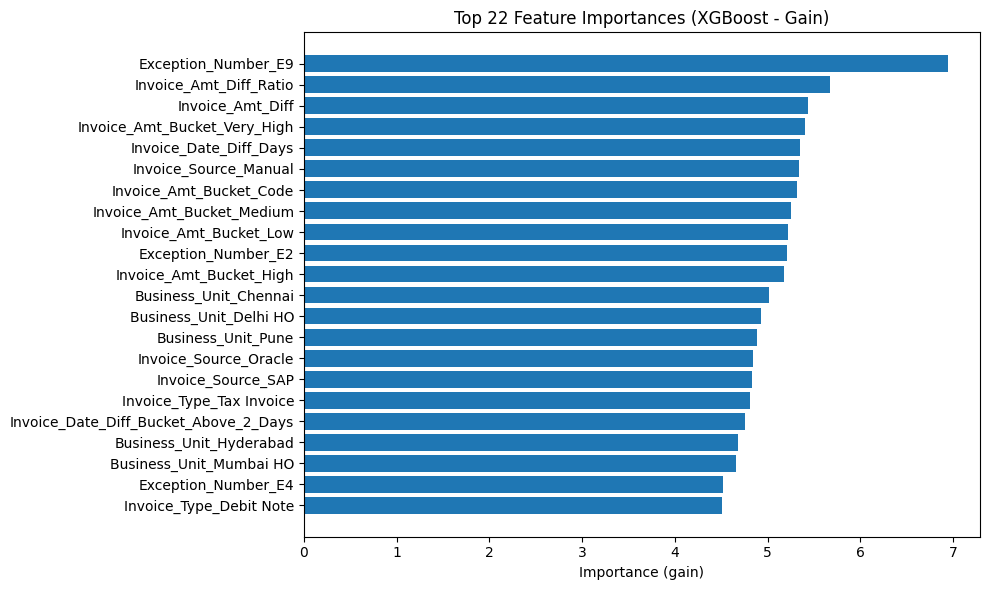

In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
)
from xgboost import XGBClassifier


# ==========================================================
# PATHS (single source of truth)
# ==========================================================
DATA_PATH = "D:/EY_Internship/p2p07_synthetic_10k_imbalance_with_pending.csv"

FEATURE_COLUMNS_PATH = "D:/EY_Internship/feature_columns.joblib"
INVOICE_BINS_PATH = "D:/EY_Internship/invoice_amt_bins.joblib"

XGB_MODEL_PATH = "xgb_model.joblib"
XGB_FEATURE_IMPORTANCE_PATH = "xgb_feature_importances_gain.csv"


# ==========================================================
# preprocess_p2p (unchanged)
# ==========================================================
def preprocess_p2p(
    df: pd.DataFrame,
    *,
    feature_columns: list[str] | None = None,
    invoice_amt_bins: np.ndarray | None = None,
    is_training: bool = False
):
    df = df.copy()

    df["Invoice_Amount"] = pd.to_numeric(df.get("Invoice_Amount"), errors="coerce")
    df = df.dropna(subset=["Invoice_Amount"])

    if is_training:
        _, bins = pd.qcut(df["Invoice_Amount"], q=5, retbins=True, duplicates="drop")
        invoice_amt_bins = bins

    if invoice_amt_bins is not None:
        labels = ["Very_Low", "Low", "Medium", "High", "Very_High"]
        effective_k = len(invoice_amt_bins) - 1
        effective_labels = labels[:effective_k]

        df["Invoice_Amt_Bucket"] = pd.cut(
            df["Invoice_Amount"],
            bins=invoice_amt_bins,
            labels=effective_labels,
            include_lowest=True
        )
        df["Invoice_Amt_Bucket_Code"] = df["Invoice_Amt_Bucket"].cat.codes.replace(-1, np.nan)
    else:
        df["Invoice_Amt_Bucket"] = pd.qcut(
            df["Invoice_Amount"], q=5,
            labels=["Very_Low", "Low", "Medium", "High", "Very_High"],
            duplicates="drop"
        )
        df["Invoice_Amt_Bucket_Code"] = pd.qcut(
            df["Invoice_Amount"], q=5, labels=False, duplicates="drop"
        )

    df = pd.get_dummies(df, columns=["Invoice_Amt_Bucket"], drop_first=True)

    df["Invoice_Date"] = pd.to_datetime(df.get("Invoice_Date"), errors="coerce", dayfirst=True)
    df["Posting_Date"] = pd.to_datetime(df.get("Posting_Date"), errors="coerce", dayfirst=True)

    dup_lookup = df[["Doc_id", "Invoice_Amount", "Invoice_Date"]].rename(
        columns={
            "Doc_id": "Duplicate_doc_id",
            "Invoice_Amount": "Dup_Invoice_Amount",
            "Invoice_Date": "Dup_Invoice_Date",
        }
    )
    df = df.merge(dup_lookup, on="Duplicate_doc_id", how="left")

    df["Invoice_Amt_Diff"] = (df["Invoice_Amount"] - df["Dup_Invoice_Amount"]).abs()
    df["Invoice_Date_Diff_Days"] = (df["Invoice_Date"] - df["Dup_Invoice_Date"]).dt.days.abs()
    df["Invoice_Amt_Diff_Ratio"] = df["Invoice_Amt_Diff"] / (df["Invoice_Amount"] + 1)

    def date_diff_bucket(x):
        if pd.isna(x):
            return np.nan
        if x == 0:
            return "Same_Day"
        elif x <= 2:
            return "1_2_Days"
        else:
            return "Above_2_Days"

    df["Invoice_Date_Diff_Bucket"] = df["Invoice_Date_Diff_Days"].apply(date_diff_bucket)

    DROP_COLS = [
        "Doc_id", "Invoice_ID", "Vendor_Code", "Vendor_Name",
        "Vendor_GSTIN", "Invoice_Number", "Currency", "comments",
        "Duplicate_doc_id", "Exception_Type",
        "Invoice_Amt_Bucket", "Invoice_Amount", "Dup_Invoice_Amount",
    ]
    df_model = df.drop(columns=DROP_COLS, errors="ignore")

    categorical_cols = [
        "Invoice_Type",
        "Invoice_Source",
        "Business_Unit",
        "Exception_Number",
        "Invoice_Date_Diff_Bucket",
    ]
    df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

    if is_training:
        feature_columns = df_model.columns.tolist()
    else:
        if feature_columns is None:
            raise ValueError("feature_columns is required for inference.")
        for c in feature_columns:
            if c not in df_model.columns:
                df_model[c] = 0
        extra = [c for c in df_model.columns if c not in feature_columns]
        if extra:
            df_model = df_model.drop(columns=extra)
        df_model = df_model[feature_columns]

    return df_model, feature_columns, invoice_amt_bins


# ==========================================================
# Helpers: Top-K metrics for triage usefulness
# ==========================================================
def topk_metrics(y_true: np.ndarray, y_proba: np.ndarray, top_frac: float = 0.10):
    y_true = np.asarray(y_true).astype(int)
    y_proba = np.asarray(y_proba)

    n = len(y_true)
    k = max(1, int(np.ceil(top_frac * n)))

    idx = np.argsort(-y_proba)[:k]
    y_top = y_true[idx]

    tp_top = y_top.sum()
    total_pos = y_true.sum()

    precision_at_k = tp_top / k
    recall_at_k = tp_top / total_pos if total_pos > 0 else 0.0
    return precision_at_k, recall_at_k, k


# ==========================================================
# Load raw data + schema
# ==========================================================
df = pd.read_csv(DATA_PATH)
feature_columns = joblib.load(FEATURE_COLUMNS_PATH)

# ==========================================================
# Learn invoice bins from TRUE/FALSE only
# ==========================================================
df_tf = df[df["user_action_status"].isin(["TRUE", "FALSE"])].copy()
_, _, invoice_amt_bins = preprocess_p2p(df_tf, is_training=True)
joblib.dump(invoice_amt_bins, INVOICE_BINS_PATH)

# ==========================================================
# Preprocess full dataset aligned to schema
# ==========================================================
df_model, _, _ = preprocess_p2p(
    df,
    feature_columns=feature_columns,
    invoice_amt_bins=invoice_amt_bins,
    is_training=False
)

# ==========================================================
# Build training set
# ==========================================================
mask_tf = df["user_action_status"].isin(["TRUE", "FALSE"])
df_train = df_model.loc[mask_tf].copy()

df_train["y"] = df.loc[df_train.index, "user_action_status"].map({
    "FALSE": 0,
    "TRUE": 1
})

X = df_train[feature_columns]
y = df_train["y"].astype(int)

# ==========================================================
# Train / test split
# ==========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==========================================================
# XGBoost (handles imbalance via scale_pos_weight)
# ==========================================================
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

xgb = XGBClassifier(
    n_estimators=1400,
    learning_rate=0.03,
    max_depth=5,
    min_child_weight=3,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_alpha=0.0,
    reg_lambda=1.0,
    gamma=0.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    tree_method="hist",
    eval_metric="auc"
)

xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

# ==========================================================
# Evaluation
# ==========================================================
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

print("\n=== XGBoost ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
p_at_10, r_at_10, k = topk_metrics(y_test.values, y_proba, top_frac=0.10)

from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))



print("ROC-AUC:", roc_auc)
print("PR-AUC:", pr_auc)
print(f"Precision@Top10% (K={k}):", p_at_10)
print(f"Recall@Top10% (K={k}):", r_at_10)

joblib.dump(xgb, XGB_MODEL_PATH)
print("\nSaved model:", XGB_MODEL_PATH)

# ==========================================================
# Feature importance (XGBoost - Gain)
# ==========================================================

booster = xgb.get_booster()

# gain + split counts
gain_dict = booster.get_score(importance_type="gain")
weight_dict = booster.get_score(importance_type="weight")

rows = []
for feat_key, gain_val in gain_dict.items():
    # feat_key can be "f12" OR already a real feature name like "Invoice_Amt_Bucket_Code"
    if feat_key.startswith("f") and feat_key[1:].isdigit():
        idx = int(feat_key[1:])
        feat_name = feature_columns[idx]
    else:
        feat_name = feat_key

    rows.append({
        "feature": feat_name,
        "importance_gain": gain_val,
        "importance_split": weight_dict.get(feat_key, 0.0)
    })

imp = pd.DataFrame(rows).sort_values("importance_gain", ascending=False)
imp.to_csv(XGB_FEATURE_IMPORTANCE_PATH, index=False)
print("Saved feature importances:", XGB_FEATURE_IMPORTANCE_PATH)

topk_plot = 22
imp_plot = imp.head(topk_plot)

plt.figure(figsize=(10, 6))
plt.barh(imp_plot["feature"][::-1], imp_plot["importance_gain"][::-1])
plt.xlabel("Importance (gain)")
plt.title(f"Top {topk_plot} Feature Importances (XGBoost - Gain)")
plt.tight_layout()
plt.show()

